# Advanced Concepts

In this notebook we will go deep on advanced modeling concepts
1. Targets: auxiliary targets, 20d vs 60d targets
2. Eras: overlapping eras, leakage and embargos
3. Ensembles: train a ensemble on multiple targets and using CV for hyperparameter tuning

In [112]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle seaborn

## 1. Targets
So far we have learned about "the target" in the Numerai dataset. But there are actually many auxiliary targets in the Numerai dataset.

Let's revisit the training data and take a look at these targets.

In [113]:
from numerapi import NumerAPI
napi = NumerAPI()

napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

2023-04-20 18:01:04,957 INFO numerapi.utils: target file already exists
2023-04-20 18:01:04,958 INFO numerapi.utils: download complete
2023-04-20 18:01:05,365 INFO numerapi.utils: target file already exists
2023-04-20 18:01:05,366 INFO numerapi.utils: download complete


In [114]:
import pandas as pd
import json

# Feature metadata contains the names of all the targets 
feature_metadata = json.load(open("v4.1/features.json")) 
target_cols = feature_metadata["targets"]

# Load the validation data but only the target columns
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + target_cols)

In [115]:
# Let's take a look at the targets
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 7)
training_data

,era,target,target_nomi_v4_20,...,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60
id,,,,,,,
n003bba8a98662e4,0001,0.25,0.25,...,0.25,0.25,0.25
n003bee128c2fcfc,0001,0.75,0.75,...,0.75,0.75,0.75
n0048ac83aff7194,0001,0.50,0.50,...,0.25,0.25,0.25
n00691bec80d3e02,0001,0.75,0.75,...,0.50,0.75,0.50
n00b8720a2fdc4f2,0001,0.75,0.75,...,0.50,0.50,0.50
...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,...,1.00,0.75,1.00
nffd71b7f6a128df,0574,0.00,0.00,...,0.25,0.00,0.50
nffde3b371d67394,0574,0.25,0.25,...,0.75,0.50,0.75


In [116]:
# The first thing to notice here is that `target` is exactly the same as `target_nomi_v4_20`
# This means that `target_nomi_v4_20` is currently the target used for scoring but this might change in the future!
print(training_data["target"].equals(training_data["target_nomi_v4_20"]))

# For the rest of this analaysis we can ignore the `target` column
target_names = target_cols[1:]
targets_df = training_data[["era"] + target_names]

True


In [117]:
# A good way to visualize all the different targets is by grouping them by their name and time horizon suffix
pd.set_option('display.max_rows', 100)
names = list(set([t[7:-6] for t in target_names]))
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
arthur,target_nomi_v4_20,target_nomi_v4_60
waldo,target_tyler_v4_20,target_tyler_v4_60
paul,target_victor_v4_20,target_victor_v4_60
george,target_ralph_v4_20,target_ralph_v4_60
cyrus,target_waldo_v4_20,target_waldo_v4_60
jerome,target_jerome_v4_20,target_jerome_v4_60
nomi,target_janet_v4_20,target_janet_v4_60
william,target_ben_v4_20,target_ben_v4_60
janet,target_alan_v4_20,target_alan_v4_60


At a high level, each target represents a kind of stock market return at a different time horizon
- each `name` represents a different kind of stock market return
- the `_20` or `_60` suffix denotes the time horizon of the target

For example
- target `janet` could mean "stock specific return within sector and region"
- the `_20` version is based on 20 day subsequent returns
- the `_60` version is based on 60 day subsequent returns

Again, there is no need to fully understand the underlying financial concepts behind each target. The important thing to know is that they are all describing stock market returns so we expect them to have some correlation with each other. 

Numerai builds and releases these targets because we believe they can help you build better models to predict the primary target.  

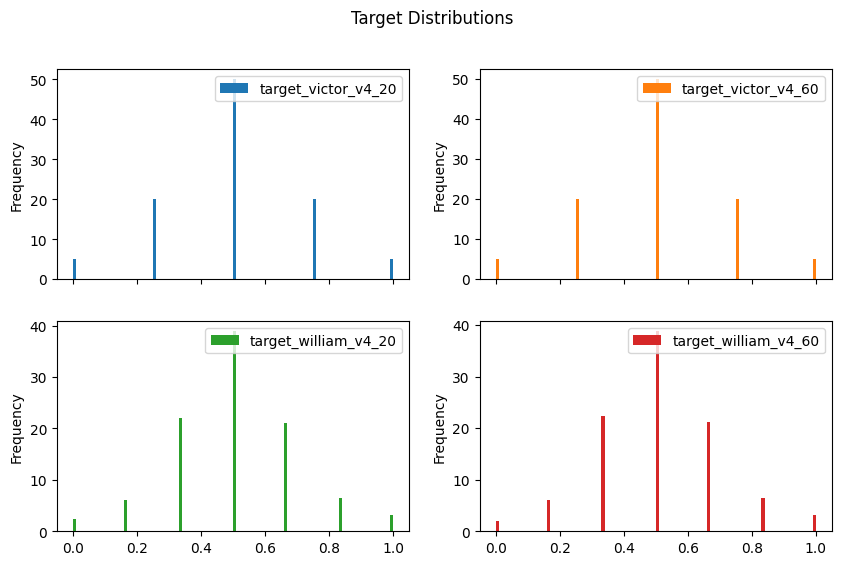

In [118]:
# It is important to note that some targets are binned into 5 bins while others are binned into 7 bins 
# But the binning for the same target name should be the same across 20 and 60 day horizons
targets_df[["target_victor_v4_20","target_victor_v4_60","target_william_v4_20","target_william_v4_60"]].plot(kind="hist", bins=100, density=True, figsize=(10, 6), title="Target Distributions", subplots=True, layout=(2, 2));

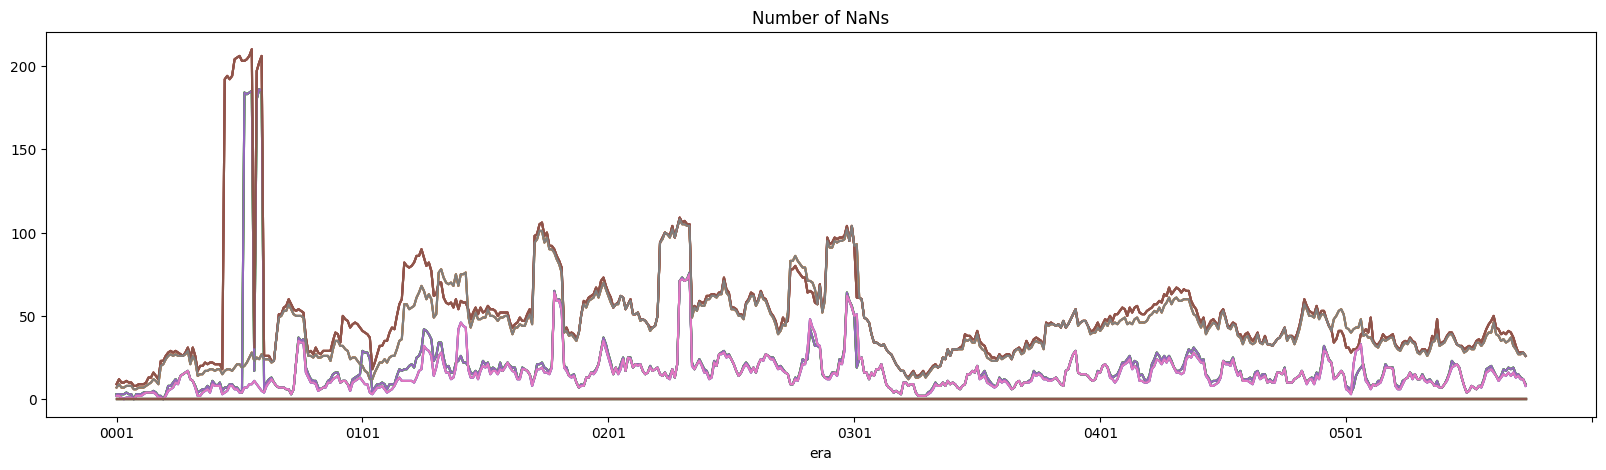

In [119]:
# It is critical to note that there can be NaN values in the auxilary targets, but the primary target will never have NaN values
# The reason why we have NaNs is because some data is just not available for some eras
# Instead of dropping these rows or imputing the values, we have chosen to leave them as NaNs to avoid any data leakage or unwanted bias
# How you handle these NaNs is up to you!
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(20, 5), title="Number of NaNs", legend=False);

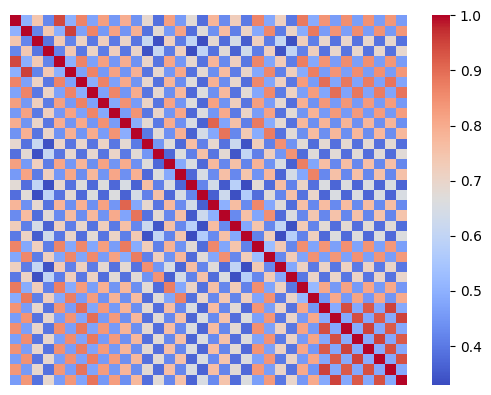

In [120]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
import seaborn as sns
sns.heatmap(targets_df[target_names].corr(), cmap="coolwarm", xticklabels=False, yticklabels=False);

## 2. Eras 

Recall that eras are each one week apart and that targets represent 20 day or 60 subsequent returns. To clarify, "days" here mean "market days" so there are only 5 days in a week. 

Putting these two ideas together, we can now see that ther eras are <ins>overlapping</ins>. The 20 day (4 week) return of era1 (week 1) span week 1-4, while the 20 day (4 week) return of era2 (week 2) span week 2-5, and so on. For 60 day (12 week) returns, the overlap of time spans are even more pronounced.

This concept of overlap is especially important to keep in mind when applying time-series cross validation or in our case era-wise cross validation. Just making sure that your test set in each split is after the train set is not enough - you need to additionally <ins>embargo</ins> some eras between train and test to make sure you are not accidentally leaking any information.

Specifically, if you train on era1 using a 20 day target, then you must embargo eras2-4, and the first era that you can safely test on is era5. If you train on era1 using a 60 day target, then you must embargo eras2-12, and the first era that you can safely test on is era13.

In [121]:
import numpy as np

def get_era_wise_cv_splits(eras, n_folds=3, embargo=0):
    # divide the eras into n_folds, adding any remainder eras to the last fold  
    len_fold = len(eras) // n_folds
    folds = [eras[i * len_fold : (i + 1) * len_fold] for i in range(n_folds)]
    folds[-1] = np.append(folds[-1], eras[n_folds * len_fold :])
    
    # create splits where test folds follow train folds
    splits = []
    for train_fold_idx in range(n_folds-1):
        # embargo eras from the tail of the training set if specified
        train = folds[train_fold_idx][:-embargo] if embargo else folds[train_fold_idx]
        test = folds[train_fold_idx+1]
        splits.append((train, test))
        
    return splits

In [122]:
# The following code is adapted from the scikit-learn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_cv = plt.cm.Paired

def plot_cv_indices(eras, cv_splits, title):
    fig, ax = plt.subplots()
    
    # add a bar for each split where nan=unused, 0=train, 1=test
    for ii, (tr, tt) in enumerate(cv_splits):   
        df = pd.DataFrame(index=eras)
        df.loc[df.index.isin(tr), "group"] = 0
        df.loc[df.index.isin(tt), "group"] = 1
        ax.scatter(x=eras.astype(int), y=[ii + 0.5] * len(eras), c=df["group"].values, marker="_", s=1, lw=10, cmap=cmap_cv, vmin=0, vmax=2)

    # formatting
    fig.set_size_inches(8, 4)
    n_splits = len(cv_splits)
    ax.set(yticks=np.arange(n_splits) + 0.5, yticklabels=list(range(n_splits)), xlabel="era", ylabel="split", ylim=[n_splits + 0.2, -0.2])
    ax.set_title(title)
    ax.legend([Patch(color=cmap_cv(0)), Patch(color=cmap_cv(0.5))], ["Train", "Test"], loc=(1.02, 0.8))
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

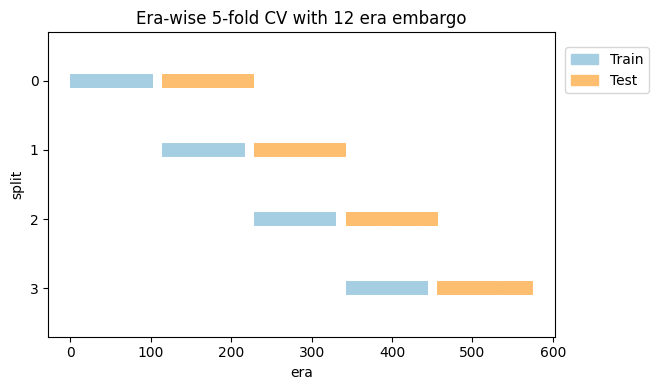

In [123]:
# Here is a visualzation of the 5-fold CV splits with a 12 era embargo suitable for models training on a 60 day target
cv_splits = get_era_wise_cv_splits(training_data["era"].unique(), n_folds=5, embargo=12)
plot_cv_indices(training_data["era"].unique(), cv_splits, "Era-wise 5-fold CV with 12 era embargo");

Era-wise time series cross validation is a deep and active area of research. For more on this topic, we highly recommend that you read up on the following
- https://forum.numer.ai/t/era-wise-time-series-cross-validation/791/10
- https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086